## Exp 3.A: a simple classifier with the barcode dataset
### Pure reimplementation of exp3
### Fuck you sugartensor

In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline


In [2]:
batch_size = 1   # batch size
image_size = 64
pixel_depth = 255.0

## Training data

-0.46735139974
1500
1.0


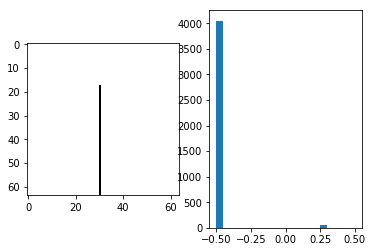

In [3]:
dir= "barcode/train/"
fn = os.listdir(dir)
total = len(fn)
total
#     change the range to switch between exp2 : [0, 1, 2, 3, 4, 5, 6]
#     and exp2.1: [1, 3, 5, 7, 9]
visible = [1, 2, 4, 7, 14]
# put all the images into this blob of size total*size*size*1
# REMEMBER to change shape of dataset
training_dataset = np.ndarray(shape = (300*len(visible), image_size, image_size, 1), dtype = np.float32)
counter = 0
# REMEMBER to change shape of training label
training_label = np.ndarray(shape = (300*len(visible)), dtype = np.float32)
for file in fn:
#     image_data = ndimage.imread(dir+file).astype(float)
    image_data = (ndimage.imread(dir+file).astype(float) - 255/2) / pixel_depth
    label = int(file.split("_")[0])
    if label in visible:
        training_label[counter] = label
        training_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
#     else:
#         print(file[0])
# shuffle dataset
permutation = np.random.permutation(counter)
training_dataset = training_dataset[permutation,:,:,:]
training_label = training_label[permutation]


print(np.sum(training_dataset)/(300*len(visible)*image_size*image_size))
print(len(training_label))
%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
image = training_dataset[100]
print(training_label[100])
ax1.imshow(image.reshape(image_size, image_size), cmap=plt.cm.Greys);

ax2.hist(image.reshape(image_size*image_size), bins=20, range=[-0.5, 0.5]);

In [4]:
train_data_node = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, 1))

train_labels_node = tf.placeholder(tf.float32, shape =(batch_size, 1))

def print_variable():
    for v in tf.global_variables():
        print(v)
# capping stddev at 0.1 is important to avoid exploding value
def conv_relu(input, kernel_shape, bias_shape, stride = 2):
    weights = tf.get_variable("weights", kernel_shape, initializer=tf.truncated_normal_initializer(stddev=0.1))
    biases = tf.get_variable("biases", bias_shape, initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(input, weights, strides = [1, stride, stride, 1], padding = 'SAME')
    return tf.nn.relu(conv+biases)
def fully_connected(input, out_shape):
    input_shape = input.get_shape().as_list()
    batch = input_shape[0]
    flattened_size = input_shape[1]
    weights = tf.get_variable("weights", [flattened_size, out_shape], 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    biases = tf.get_variable("biases", [out_shape],
                            initializer = tf.constant_initializer(0.1))
    return tf.matmul(input, weights) + biases
def network(input_images):
    with tf.variable_scope("conv1"):
        # kernel is in shape height*width*in*out
        conv_relu1 = conv_relu(input_images, [4, 4, 1, 32], [32])
    with tf.variable_scope("conv2"):
        conv_relu2 = conv_relu(conv_relu1, [4, 4, 32, 64], [64])
    with tf.variable_scope("conv3"):
        conv_relu3 = conv_relu(conv_relu2, [4, 4, 64, 128], [128])
    with tf.variable_scope("fc1"):
        conv_relu3_shape = conv_relu3.get_shape().as_list()
        reshape_conv3 = tf.reshape(conv_relu3,
                                [conv_relu3_shape[0], conv_relu3_shape[1]*conv_relu3_shape[2]*conv_relu3_shape[3]])
        fc1 = tf.nn.relu(fully_connected(reshape_conv3, 1024))
    with tf.variable_scope("fc2"):
        fc2 = tf.nn.relu(fully_connected(fc1, 10))
    with tf.variable_scope("kernel"):
        kernel = tf.concat([tf.pow(fc2, 2), fc2], 1)
        result = fully_connected(kernel, 1)
    return result
    
output = network(train_data_node)
loss = tf.reduce_mean(tf.squared_difference(output, train_labels_node))


fc1_weights = [v for v in tf.global_variables() if v.name == "fc1/weights:0"][0]
fc1_biases = [v for v in tf.global_variables() if v.name == "fc1/biases:0"][0]
fc2_weights = [v for v in tf.global_variables() if v.name == "fc2/weights:0"][0]
fc2_biases = [v for v in tf.global_variables() if v.name == "fc2/biases:0"][0]
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))

loss += 5e-4 * regularizers

train_size = len(training_label)

batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.0001,                # Base learning rate.
  batch * batch_size,  # Current index into the dataset.
  train_size,          # Decay step. Decay after every epoch (seeing all example)
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.AdamOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)


In [5]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)

sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.as_default()

tf.global_variables_initializer().run()

In [6]:
batch_data = training_dataset[:batch_size]
batch_labels = training_label[:batch_size].reshape((batch_size, 1))


_, l, lr, predictions = sess.run(
  [optimizer, loss, learning_rate, output],
  feed_dict={train_data_node: batch_data,
             train_labels_node: batch_labels})

print("Done")

Done


In [7]:
print_variable()



<tf.Variable 'global_step:0' shape=() dtype=int32_ref>
<tf.Variable 'conv1/weights:0' shape=(4, 4, 1, 32) dtype=float32_ref>
<tf.Variable 'conv1/biases:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'conv2/weights:0' shape=(4, 4, 32, 64) dtype=float32_ref>
<tf.Variable 'conv2/biases:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv3/weights:0' shape=(4, 4, 64, 128) dtype=float32_ref>
<tf.Variable 'conv3/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'fc1/weights:0' shape=(8192, 1024) dtype=float32_ref>
<tf.Variable 'fc1/biases:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'fc2/weights:0' shape=(1024, 10) dtype=float32_ref>
<tf.Variable 'fc2/biases:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'kernel/weights:0' shape=(20, 1) dtype=float32_ref>
<tf.Variable 'kernel/biases:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'Variable:0' shape=() dtype=int32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.

In [8]:
var_23 = [v for v in tf.global_variables() if v.name == "conv1/weights:0"][0]
print(sess.run(var_23))

[[[[ -1.99053809e-01  -7.44020715e-02  -1.24661475e-01   8.01265612e-02
     -4.37104963e-02   4.36762087e-02   5.99976815e-02   1.15336552e-01
      7.14788272e-04   8.63619000e-02  -8.15904513e-02  -2.44693235e-02
     -1.61531597e-01   8.67417306e-02   9.46746022e-02  -8.03697482e-02
      4.85168472e-02   8.46753567e-02  -4.00047265e-02   2.78897192e-02
      5.29607274e-02  -5.62932752e-02  -1.37443662e-01  -1.48446918e-01
     -3.42981890e-02   6.07962161e-02   5.14490567e-02   3.37236300e-02
      8.64395499e-02  -8.48618895e-02  -1.65788177e-02  -1.03640355e-01]]

  [[  1.95826352e-01   1.14477508e-01   3.59015428e-02  -1.07955068e-01
     -7.59413987e-02  -8.04913118e-02  -1.08434800e-02   6.75413236e-02
      1.72568887e-01  -3.66455466e-02  -4.52249907e-02  -7.01508895e-02
     -6.13531796e-04  -1.14761941e-01   1.02513120e-01  -4.59832810e-02
      8.05846080e-02  -8.38233903e-02   5.87331019e-02   8.04345086e-02
     -3.87987457e-02   8.29314590e-02   8.43048096e-02  -1.49

In [9]:
for step in range(100000):
    offset = (step * batch_size) % (train_size - batch_size)
    batch_data = training_dataset[offset:batch_size+offset]
    batch_labels = training_label[offset:batch_size+offset].reshape((batch_size, 1))
    
    _, l, lr, predictions = sess.run(
      [optimizer, loss, learning_rate, output],
      feed_dict={train_data_node: batch_data,
             train_labels_node: batch_labels})
    
    if step % 500 ==0:
        print('Step %d' %step)
        print(predictions)
        print('Mini-batch loss: %.5f Learning rate: %.5f' % (l, lr))

Step 0
[[ 6.78777122]]
Mini-batch loss: 23.99713 Learning rate: 0.00010
Step 500
[[ 2.75266409]]
Mini-batch loss: 12.79630 Learning rate: 0.00010
Step 1000
[[ 10.70023441]]
Mini-batch loss: 21.77671 Learning rate: 0.00010
Step 1500
[[ 3.86252069]]
Mini-batch loss: 10.33881 Learning rate: 0.00009
Step 2000
[[ 2.15028882]]
Mini-batch loss: 10.05876 Learning rate: 0.00009
Step 2500
[[ 6.88041496]]
Mini-batch loss: 9.85802 Learning rate: 0.00009
Step 3000
[[ 15.6029501]]
Mini-batch loss: 12.25310 Learning rate: 0.00009
Step 3500
[[ 3.73951483]]
Mini-batch loss: 9.60291 Learning rate: 0.00009
Step 4000
[[ 12.46959877]]
Mini-batch loss: 11.72317 Learning rate: 0.00009
Step 4500
[[ 2.11031699]]
Mini-batch loss: 9.23307 Learning rate: 0.00009
Step 5000
[[ 1.86651957]]
Mini-batch loss: 9.07859 Learning rate: 0.00009
Step 5500
[[ 0.85838169]]
Mini-batch loss: 8.91223 Learning rate: 0.00009
Step 6000
[[ 1.47897351]]
Mini-batch loss: 8.94855 Learning rate: 0.00008
Step 6500
[[ 1.82816637]]
Mini-ba

# Validation


In [10]:
dir= "barcode/valid/"
fn = os.listdir(dir)
total = len(fn)
total
#     change the range to switch between exp2 : [0, 1, 2, 3, 4, 5, 6]
#     and exp2.1: [1, 3, 5, 7, 9]
visible = [1, 2, 4, 7, 14]
# put all the images into this blob of size total*size*size*1
# REMEMBER to change shape of dataset
valid_dataset = np.ndarray(shape = (3000*len(visible), image_size, image_size, 1), dtype = np.float32)
counter = 0
# REMEMBER to change shape of valid label
valid_label = np.ndarray(shape = (3000*len(visible)), dtype = np.float32)
for file in fn:
#     image_data = ndimage.imread(dir+file).astype(float)
    image_data = (ndimage.imread(dir+file).astype(float) - 255/2) / pixel_depth
    label = int(file.split("_")[0])
    if label in visible:
        valid_label[counter] = label
        valid_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
#     else:
#         print(file[0])
# shuffle dataset
permutation = np.random.permutation(counter)
valid_dataset = valid_dataset[permutation,:,:,:]
valid_label = valid_label[permutation]



In [11]:
offset = 0
batch_data_all = valid_label
results = []
correct = 0
for i in range(len(valid_label)):
    batch_data = valid_dataset[offset+i:offset+i+1]
    batch_labels = valid_label[offset+i:offset+i+1].reshape((batch_size, 1))
    predictions = sess.run(output, feed_dict={train_data_node: batch_data})[0][0]
    predictions = float(int(round(predictions)))
    if predictions == batch_data_all[i]:
        correct+=1
    results.append(predictions)
print(batch_data_all[100:120])
print(results[100:120])
print("accuracy: "+str(correct/len(valid_label)))
confusions = np.zeros([10, 10], np.float32)


[  4.   2.   4.   2.   4.   1.   4.   7.   1.   7.   2.   7.   1.   4.   7.
   2.   1.   4.  14.   2.]
[4.0, 2.0, 4.0, 2.0, 4.0, 1.0, 4.0, 7.0, 1.0, 7.0, 2.0, 7.0, 1.0, 4.0, 7.0, 2.0, 1.0, 4.0, 14.0, 2.0]
accuracy: 0.944
